In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import math
%matplotlib inline

#cv
import cv2
import math
from PIL import Image

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐
# #그래프 세팅
# font = {'family': 'serif',
#         'color':  'white',
#         'weight': 'normal',
#         'size': 16,
#         }

#### PATH

In [4]:
org_img_path='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/01_data/'
bit_mask_img_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/01_bit_mask_test/'
cut_img_path = '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/02_cut_test/'
rotation_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/03_rotation/'
rotation_cropped_path = '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/04_rotation_cropped/'
contrast_path = '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/05_roi_contrast/'
resized_contrast_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/05_1_roi_contrast(resized)/'

#### IMAGE

In [5]:
img_org = cv2.imread(org_img_path+'org001.jpg')
img_org2 = cv2.imread(org_img_path+'org002.jpg')
rot_img1 = cv2.imread(rotation_path+'rot_001.jpg')
rot_img2 = cv2.imread(rotation_path+'rot_002.jpg')

#### def

In [6]:
#이미지 함수
def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

In [8]:
#masking, return 까먹지 말기 흑흑 
def get_mask(img):
#     img = cv2.imread(img_path+"/org001.jpg")
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    # show(img)

    # #블러 02
    # #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    # show(img)
    # #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask

#     show(mask)
    #그 다음에 가지고 있는 이미지 모두 마스크 처리 --> 오래걸림

In [9]:
# 클라헤
def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize =(8,8))
    img2 = clahe.apply(img)
    
    res = no.hstack((img, img2))
    
    cv2.imshow('clahe', res)

#### 윤곽선 추출 MORPH_CLOSE + Canny_edge

In [11]:
rot_img2 = cv2.imread(rotation_path+'rot_002.jpg')

In [13]:
# 마스크처리하고 로테이션 된 이미지 활용

kernel2 = np.ones((11, 11), np.uint8)
result2 = cv2.morphologyEx(rot_img2, cv2.MORPH_CLOSE, kernel2)
canny_test = cv2.Canny(result2, 50,53)
show(canny_test)

img_test=canny_test.copy()

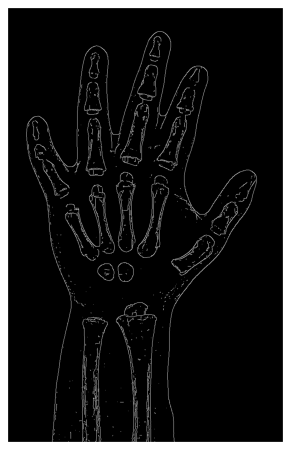

In [14]:
show(img_test)

#### 윤곽선 확대

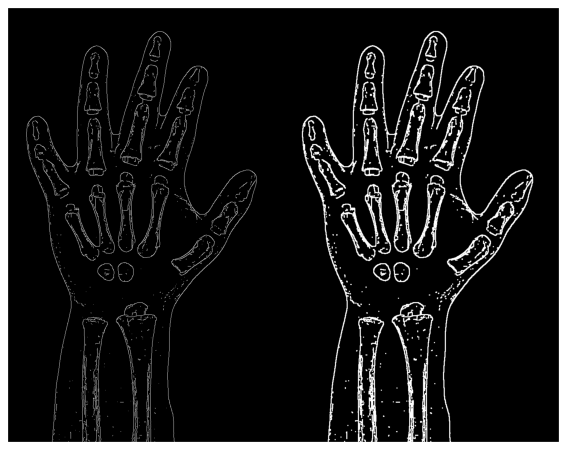

In [18]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dst = cv2.dilate(img_test, k)
thick_line = dst.copy()

#합쳐서 보기
merged = np.hstack((img_test, thick_line))
show(merged)

#### 노이즈제거

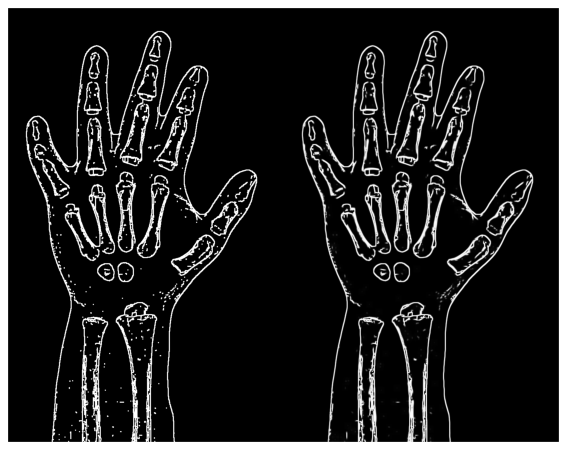

In [20]:
denoised_img = cv2.fastNlMeansDenoising(thick_line, h=60, templateWindowSize = 10, searchWindowSize = 21 )
show(denoised_img)
no_noise = denoised_img.copy()
merged = np.hstack((thick_line, no_noise))
show(merged)

#### 손 윤곽선 삭제

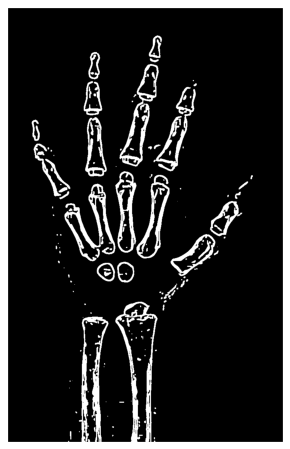

In [21]:
im = cv2.normalize(no_noise, None, alpha=0, beta= 255, norm_type = cv2.NORM_MINMAX)
res, im = cv2.threshold(im, 20, 255,cv2.THRESH_BINARY)

cv2.floodFill(im, None, (0,0), 255)
cv2.floodFill(im, None, (0,0), 0)

#이미지저장  (from PIL import Image)
Image.fromarray(im)
no_boder = im.copy()
show(no_boder)